# This script is meant to take .npz files and create data visualizations

In [1]:
# Import Standard Libraries
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
import scipy

In [ ]:
def get_drug_times(batch_id: str, drug_name: str, start_delay=datetime.timedelta(), length=None):

    # start_delay = datetime.timedelta of delay from "drug recording start time"
    # length = datetime.timedelta of length of recording from start time (accounting to the delay)
    drug_times = {
        "O9-12":{
            "Control":[datetime.datetime(2023, 5, 3, 17, 33), datetime.datetime(2023, 5, 18, 12, 10)],
            "4-AP":[datetime.datetime(2023, 5, 18, 12, 25), datetime.datetime(2023, 5, 18, 18, 15)],
            "No Drug":[datetime.datetime(2023, 5, 18, 18, 30), datetime.datetime(2023, 5, 19, 9, 15)],
            "Bicuculline":[datetime.datetime(2023, 5, 19, 9, 30), datetime.datetime(2023, 5, 19, 15, 25)],
            "Tetrodotoxin":[datetime.datetime(2023, 5, 19, 15, 40), datetime.datetime(2023, 5, 19, 21, 40)],
        },
        "O13-16":{
            "Control":[datetime.datetime(2023, 5, 25, 19, 18), datetime.datetime(2023, 6, 8, 18, 50)],
            "4-AP":[datetime.datetime(2023, 6, 8, 19, 5), datetime.datetime(2023, 6, 8, 23, 35)],
            "No Drug":[datetime.datetime(2023, 6, 8, 23, 50), datetime.datetime(2023, 6, 9, 10, 5)],
            "Bicuculline":[datetime.datetime(2023, 6, 9, 10, 20), datetime.datetime(2023, 6, 9, 15, 25)],
            "Tetrodotoxin":[datetime.datetime(2023, 6, 9, 15, 40), datetime.datetime(2023, 6, 9, 21, 40)],
        },
        "O17-20":{
            "Control":[datetime.datetime(2023, 6, 22, 15, 40), datetime.datetime(2023, 7, 12, 12, 55)],
            "4-AP":[datetime.datetime(2023, 7, 12, 13, 10), datetime.datetime(2023, 7, 12, 18, 10)],
            "No Drug":[datetime.datetime(2023, 7, 12, 18, 25), datetime.datetime(2023, 7, 13, 12, 20)],
            "Bicuculline":[datetime.datetime(2023, 7, 13, 12, 35), datetime.datetime(2023, 7, 13, 18, 0)],
            "Tetrodotoxin":[datetime.datetime(2023, 7, 13, 18, 15), datetime.datetime(2023, 7, 14, 0, 15)],
        },
        "O21-24":{
            "Control":[datetime.datetime(2024, 7, 1, 13, 53), datetime.datetime(2024, 7, 9, 13, 25)],
            "4-AP":[datetime.datetime(2024, 7, 9, 13, 45), datetime.datetime(2024, 7, 9, 17, 45)],
            "No Drug":[datetime.datetime(2024, 7, 9, 18, 0), datetime.datetime(2024, 7, 10, 10, 35)],
            "Bicuculline":[datetime.datetime(2024, 7, 10, 10, 50), datetime.datetime(2024, 7, 10, 15, 50)],
            "Tetrodotoxin":[datetime.datetime(2024, 7, 10, 16, 5), datetime.datetime(2024, 7, 10, 22, 5)],
        },
        "O25-28":{
            "Control":[datetime.datetime(2024, 10, 1, 16, 26), datetime.datetime(2024, 10, 14, 12, 50)],
            "4-AP":[datetime.datetime(2024, 10, 14, 13, 5), datetime.datetime(2024, 10, 14, 18, 0)],
            "No Drug":[datetime.datetime(2024, 10, 14, 18, 25), datetime.datetime(2024, 10, 15, 13, 15)],
            "Bicuculline":[datetime.datetime(2024, 10, 15, 13, 30), datetime.datetime(2024, 10, 15, 18, 25)],
            "Tetrodotoxin":[datetime.datetime(2024, 10, 15, 18, 35), datetime.datetime(2024, 10, 16, 0, 35)],
        },
    }

    start_time, end_time = drug_times[batch_id][drug_name]

    # Apply Delay
    start_time += start_delay

    # Segment Recording based on length (if given)
    if length is not None:
        end_time = start_time + length

    return start_time, end_time

def make_session_dict(batch_ids, drug_names, start_delay=datetime.timedelta(), length=None):

    session = {}

    for batch in batch_ids:
        session[batch] = {}

        for drug in drug_names:
            session[batch][drug] = get_drug_times(batch, drug, start_delay, length)
    
    return session

def get_batch_folder(session_times, processed_data_dir):
    # Get folder (stored in processed_date_dir) which contains session times

    start_time, end_time = session_times
    batch_folders = os.listdir(processed_data_dir)

    for batch_folder in batch_folders:

        batch_files = os.listdir(os.path.join(processed_data_dir, batch_folder))

        file_format = '%y%m%d.npz'
        batch_dates = [datetime.datetime.strptime(file, file_format).date() for file in batch_files]

        if start_time.date() in batch_dates and end_time.date() in batch_dates:
            return batch_folder
    
    raise Exception("One or both of session time dates not found in processed_data_dir")

def get_time_array(type_str = False):

    # Create an empty array to store time objects
    time_array = np.empty(24 * 60, dtype=object)
    
    # Fill the array with time objects for each minute of the day
    for hour in range(24):
        for minute in range(60):
            index = hour * 60 + minute
            time_object = datetime.time(hour=hour, minute=minute)

            if type_str:
                time_array[index] = time_object.strftime("%H%M")
            else:
                time_array[index] = time_object
    
    return time_array

In [238]:
# Create a Function to Fetch all data between session times in a session dictionary
def fetch_data(session_times: tuple, processed_data_dir):

    # IMPEDANCE FILTER
    I1 = 50000
    I2 = 2000000

    # find all recorded data between session times
    start_time, end_time = session_times

    # get batch folder (in processed_data_dir)
    batch_folder = get_batch_folder(session_times=session_times, processed_data_dir=processed_data_dir)

    # get time array (all minutes across a day)
    time_array = get_time_array()

    # get files for wanted batch recording (sort by date)
    batch_files = np.sort(np.array(os.listdir(os.path.join(processed_data_dir, batch_folder))))

    # get dates for batch files
    file_format = '%y%m%d.npz'
    batch_dates = np.array([datetime.datetime.strptime(file, file_format).date() for file in batch_files])

    # get files for dates within session_times 
    files = batch_files[(start_time.date() <= batch_dates) & (batch_dates <= end_time.date())]
    
    for file in files:
        print(f"Processing {file}")
        
        # extract data from file
        file_dict = dict(np.load(os.path.join(processed_data_dir, batch_folder, file)))

        # SOMETHING TO FIX LATER
        # I don't like having time = axis0, I'm changing the order to 4 x 32 x 1440 x 10
        file_dict["data"] = np.transpose(file_dict["data"], (1, 2, 0, 3))
        file_dict["rms_mask"] = np.transpose(file_dict["rms_mask"], (1, 2, 0))

        file_data = file_dict["data"]

        # create (4 x 32 x 1440 x 4) logical array of all masks [minute, rms, inside, impedance]
        file_mask = np.stack(
            (
                np.tile(file_dict["minute_mask"][np.newaxis, np.newaxis, :], (4, 32, 1)), # 1440 -> 4 x 32 x 1440
                file_dict["rms_mask"], # 4 x 32 x 1440
                np.tile(file_dict["elec_inside_mask"][:, :, np.newaxis], (1, 1, 1440)), # 4 x 32 -> 4 x 32 x 1440
                np.tile(((I1 <= file_dict["impedance_values"]) & (file_dict["impedance_values"] <= I2))[:, :, np.newaxis], (1, 1, 1440)) # 4 x 32 -> 4 x 32 x 1440
            ),
            axis = -1
        )

        # time indexing (baseed on start and end time)
        t_idx = np.full(1440, True, dtype=bool)
        if file == files[0]:
            # remove data before start time
            t_idx = t_idx & (time_array>=start_time.time())
        
        if file == files[-1]:
            # remove data afteer end time
            t_idx = t_idx & (time_array<=end_time.time())
        file_data = file_data[:, :, t_idx, :]
        file_mask = file_mask[:, :, t_idx, :]       

        # concatenate file array with session array
        if file == files[0]:
            # initialize array
            data = file_data
            mask = file_mask

        else:
            # concatenate array (along time (1440) axis)
            data = np.concatenate((data, file_data), axis=2)
            mask = np.concatenate((mask, file_mask), axis=2)
        
        # Print summary values (mask)
        minute_mask = file_mask[0,0,:,0]
        print(f"{np.sum(minute_mask)}/{file_mask.shape[2]} minutes sucessfully recorded")
        
        print(f"{np.round((np.sum(file_mask[:,:,:,1])/np.size(file_mask[:,:,minute_mask,1]))*100, decimals=2)}% of data in valid rms range")
        print(f"{np.sum(file_mask[:,:,0,2])}/128 electrodes inside organoids")
        print(f"{np.sum(file_mask[:,:,0,3])}/128 electrodes in valid impedance range")
        print(f"{np.round((np.sum(np.all(file_mask, axis=3))/np.size(file_mask[:,:,:,0]))*100, decimals=2)}% of data pass all filters")
        print("")
  

    return data, mask


In [210]:
def get_data_dict(session_dict: dict, processed_data_dir):

    # return a dictionary organized the same way as the session_dict replacing the session times with the data between them

    data_dict = {}

    for key, value in session_dict.items():
        
        print(f"{key}:")
        
        # account for different number of layers throughout dict
        if isinstance(value, dict):
            data_dict[key] = get_data_dict(value, processed_data_dir)

        # once reached the "value" layer (get data)
        if isinstance(value, tuple):
            data_dict[key] = fetch_data(session_times=value, processed_data_dir=processed_data_dir)
    
    return data_dict
            

In [352]:
def get_total_mask(mask_array, minute=True, rms=True, elec_inside=True, impedance=True):
    
    filter_idx = [minute, rms, elec_inside, impedance]
    return np.all(mask_array[:,:,:,filter_idx], axis=3)

def apply_mask(data, mask):

    if not data.shape == mask.shape:
        raise IndexError("Size of data needs to match the size of mask")
    
    array = np.full(data.shape, np.nan)
    array[mask] = data[mask]

    return array
    


In [291]:
np.array([1,2,3])[np.array([True, True, True])]

array([1, 2, 3])

In [233]:
# Filter Line Plots (time vs valid channels)

# input = 2 layer dict [batch, days]
# output = 4x1 figure (each organoid) with drug conditions labeled on x-axis

# make session dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]

session = {}
for batch_id in batch_ids:
    session[batch_id] = {}

    recording_start = get_drug_times(batch_id, "Control")[0]
    recording_end = get_drug_times(batch_id, "Tetrodotoxin")[1]

    # Iterate through the range of dates
    date_list = []
    date = recording_start.date()
    while date <= recording_end.date():
        # Append the date part of the datetime object to the list
        date_list.append(date)
        # Increment the current datetime by one day
        date += datetime.timedelta(days=1)
    
    for date in date_list:

        if date == date_list[0]:
            session[batch_id][date] = (recording_start, recording_start+datetime.timedelta(hours=1))

        elif date == date_list[-1]:
            session[batch_id][date] = (recording_end-datetime.timedelta(hours=1), recording_end)

        else:
            session[batch_id][date] = (datetime.datetime.combine(date, datetime.time(hour=2, minute=0)), datetime.datetime.combine(date, datetime.time(hour=3, minute=0)))
    



In [ ]:
processed_data_dir = os.path.join(os.getcwd(), "processed_data")
data = get_data_dict(session, processed_data_dir)

O9-12:
2023-05-03:
Processing 230503.npz
61/61 minutes sucessfully recorded
89.61% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
25.58% of data pass all filters

2023-05-04:
Processing 230504.npz
61/61 minutes sucessfully recorded
79.03% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
21.94% of data pass all filters

2023-05-05:
Processing 230505.npz
61/61 minutes sucessfully recorded
90.78% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
22.53% of data pass all filters

2023-05-06:
Processing 230506.npz
61/61 minutes sucessfully recorded
75.77% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.74% of data pass all filters

2023-05-07:
Processing 230507.npz
61/61 minutes sucessfully recorded
75.78% of data in valid rms range
82/128 electrodes inside organoids

/var/folders/kj/qkc_fs3j2rx6nfm3mpsqdf940000gn/T/ipykernel_2534/1724973464.py:78: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{np.round((np.sum(file_mask[:,:,:,1])/np.size(file_mask[:,:,minute_mask,1]))*100, decimals=2)}% of data in valid rms range")


61/61 minutes sucessfully recorded
72.61% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.57% of data pass all filters

2023-05-12:
Processing 230512.npz
61/61 minutes sucessfully recorded
70.31% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.75% of data pass all filters

2023-05-13:
Processing 230513.npz
61/61 minutes sucessfully recorded
70.36% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.75% of data pass all filters

2023-05-14:
Processing 230514.npz
61/61 minutes sucessfully recorded
69.53% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.75% of data pass all filters

2023-05-15:
Processing 230515.npz
61/61 minutes sucessfully recorded
69.53% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance ran

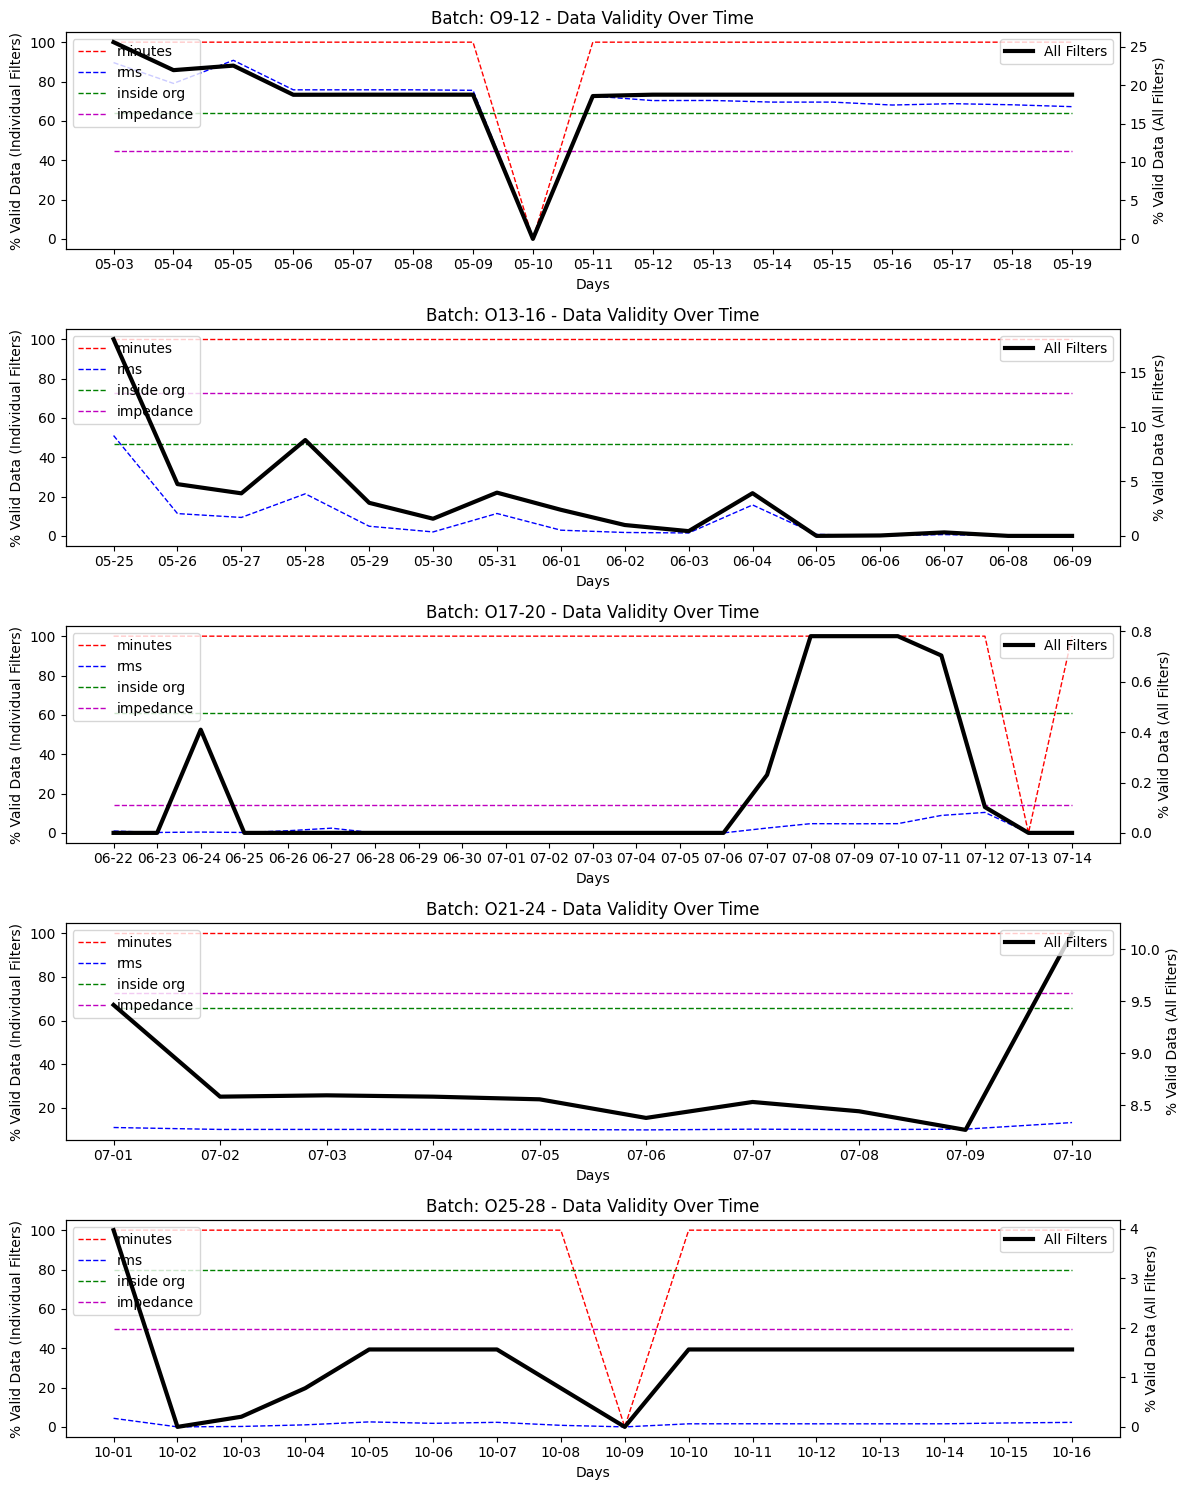

In [281]:
# Filter Line Plots (time vs valid channels)
# input = 2 layer dict [batch, days]
# output = Bx1 figure (days vs % data which passes)
F = 5
B = len(data)
filter_names = ["minutes", "rms", "inside org", "impedance"]
colors = ['r', 'b', 'g', 'm']
# Create a figure with Bx1 subplots
fig, axs = plt.subplots(B, 1, figsize=(12, 3*B))

for i, (batch, batch_dict) in enumerate(data.items()):

    # Need 
    # day vector
    # minute mask / rms mask / inside mask / impedance mask / all mask
    days = []
    D = len(batch_dict)
    batch_data = np.zeros((F, D))
    for d, (day, (_, mask)) in enumerate(batch_dict.items()): # d = day index

        total_data = np.size(mask[:,:,:,0])

        mask_list = []
        for f in range(F-1): # f = filter index

            mask_f = mask[:,:,:,f]
            batch_data[f, d] = (np.sum(mask_f) / total_data) * 100 # % of valid data for that filter

        batch_data[F-1, d] = (np.sum(np.all(mask, axis=3)) / total_data) * 100 # % of valid data for all filters
        days.append(day.strftime("%m-%d"))

    # Create a subplot for this batch
    ax1 = axs[i]
    
    # Plot all but the last line on ax1
    for f in range(F - 1):
        ax1.plot(days, batch_data[f], color=colors[f], label=filter_names[f], linewidth=1, linestyle='dashed')

    # Set labels and title for ax1
    ax1.set_xlabel('Days')
    ax1.set_ylabel('% Valid Data (Individual Filters)')
    ax1.set_title(f'Batch: {batch} - Data Validity Over Time')
    ax1.legend(loc='upper left')

    # Create a secondary axis for the last line
    ax2 = ax1.twinx()

    # Plot the last line on ax2
    ax2.plot(days, batch_data[F-1], color='k', label='All Filters', linewidth=3)

    # Set labels for ax2
    ax2.set_ylabel('% Valid Data (All Filters)')
    ax2.legend(loc='upper right')

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()




# Investigate Drug Reactions

In [412]:
# Make Session Dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]
drug_names = ["Control", "4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]

session = make_session_dict(
    batch_ids=batch_ids, 
    drug_names=drug_names,
    length=datetime.timedelta(hours=5)
    )


In [413]:
processed_data_dir = os.path.join(os.getcwd(), "processed_data")
data = get_data_dict(session, processed_data_dir)


O9-12:
Control:
Processing 230503.npz
301/301 minutes sucessfully recorded
83.99% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
23.63% of data pass all filters

4-AP:
Processing 230518.npz
301/301 minutes sucessfully recorded
65.92% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.73% of data pass all filters

No Drug:
Processing 230518.npz
301/301 minutes sucessfully recorded
66.12% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.75% of data pass all filters

Bicuculline:
Processing 230519.npz
301/301 minutes sucessfully recorded
66.3% of data in valid rms range
82/128 electrodes inside organoids
57/128 electrodes in valid impedance range
18.75% of data pass all filters

Tetrodotoxin:
Processing 230519.npz
301/301 minutes sucessfully recorded
66.08% of data in valid rms range
82/128 electrodes inside organoids

/var/folders/kj/qkc_fs3j2rx6nfm3mpsqdf940000gn/T/ipykernel_2534/4006353538.py:27: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


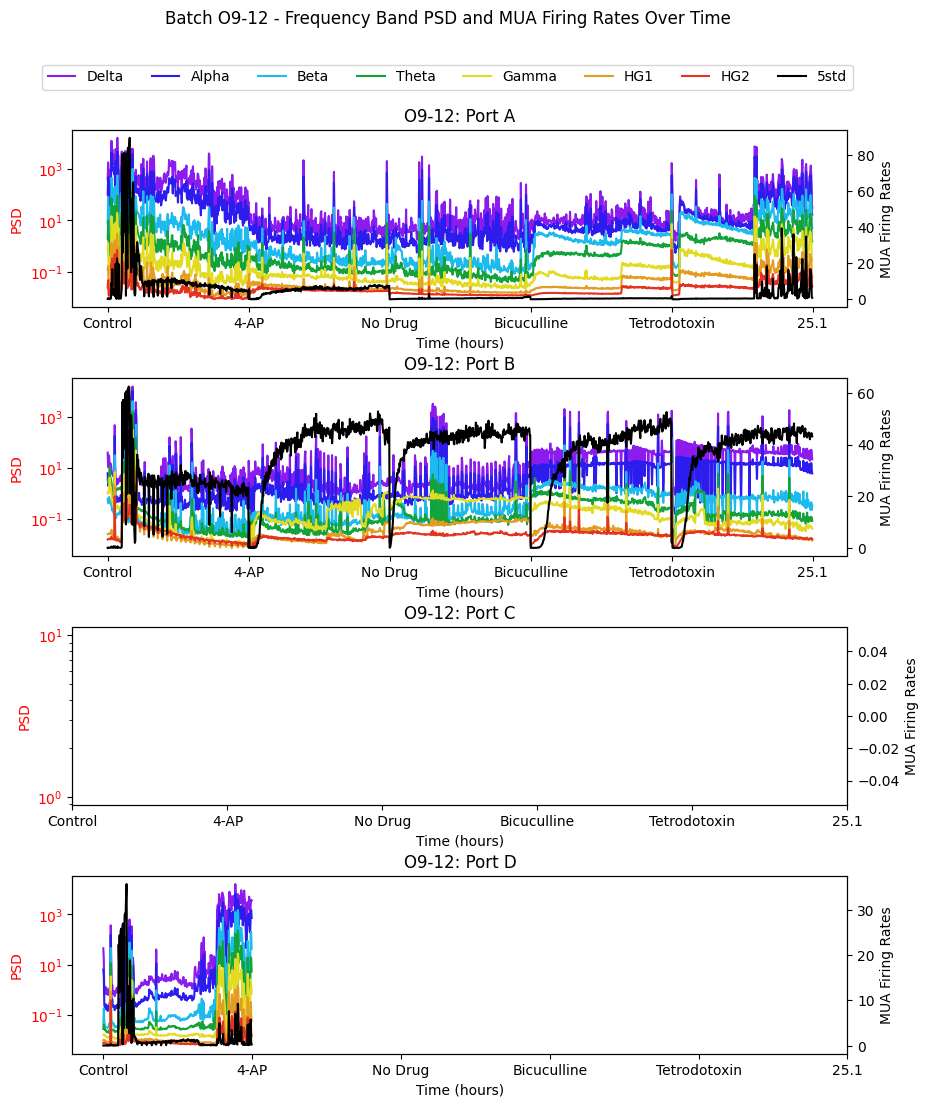

/var/folders/kj/qkc_fs3j2rx6nfm3mpsqdf940000gn/T/ipykernel_2534/4006353538.py:27: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


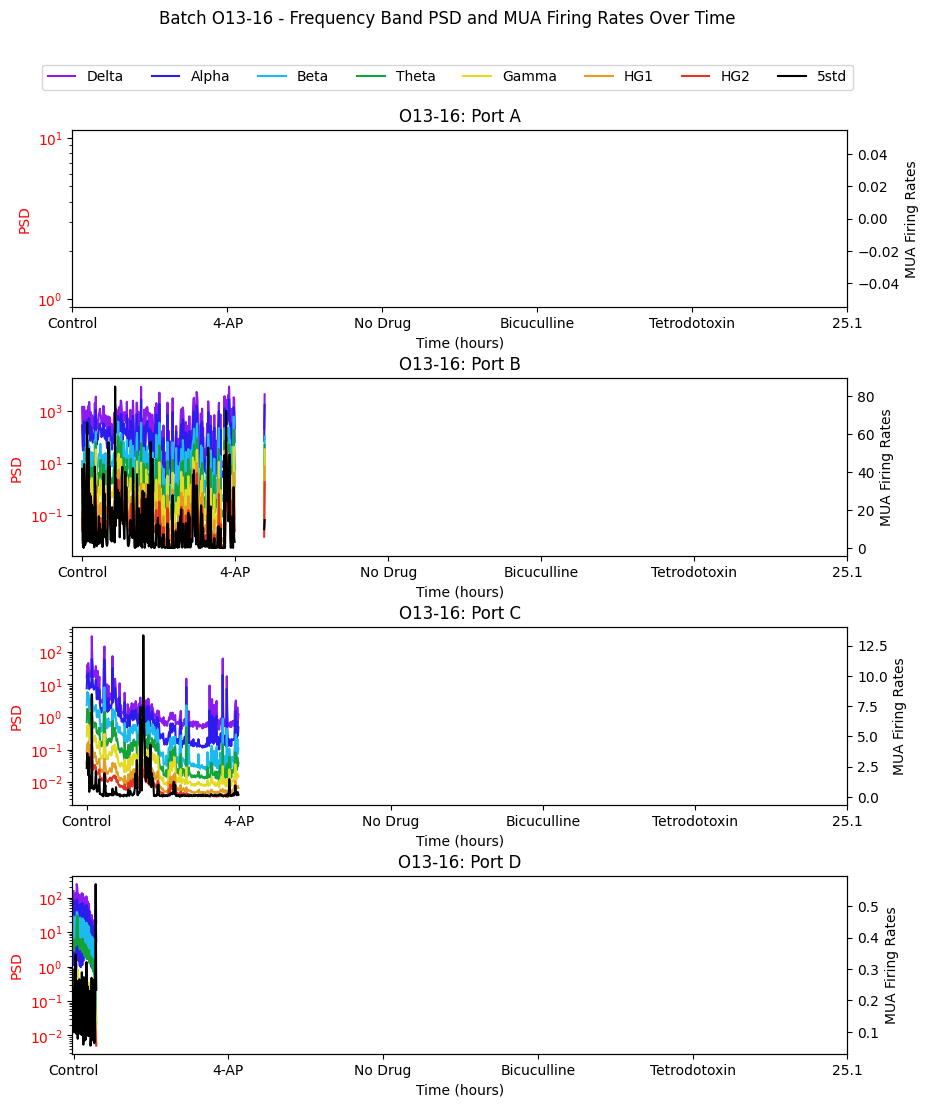

/var/folders/kj/qkc_fs3j2rx6nfm3mpsqdf940000gn/T/ipykernel_2534/4006353538.py:27: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


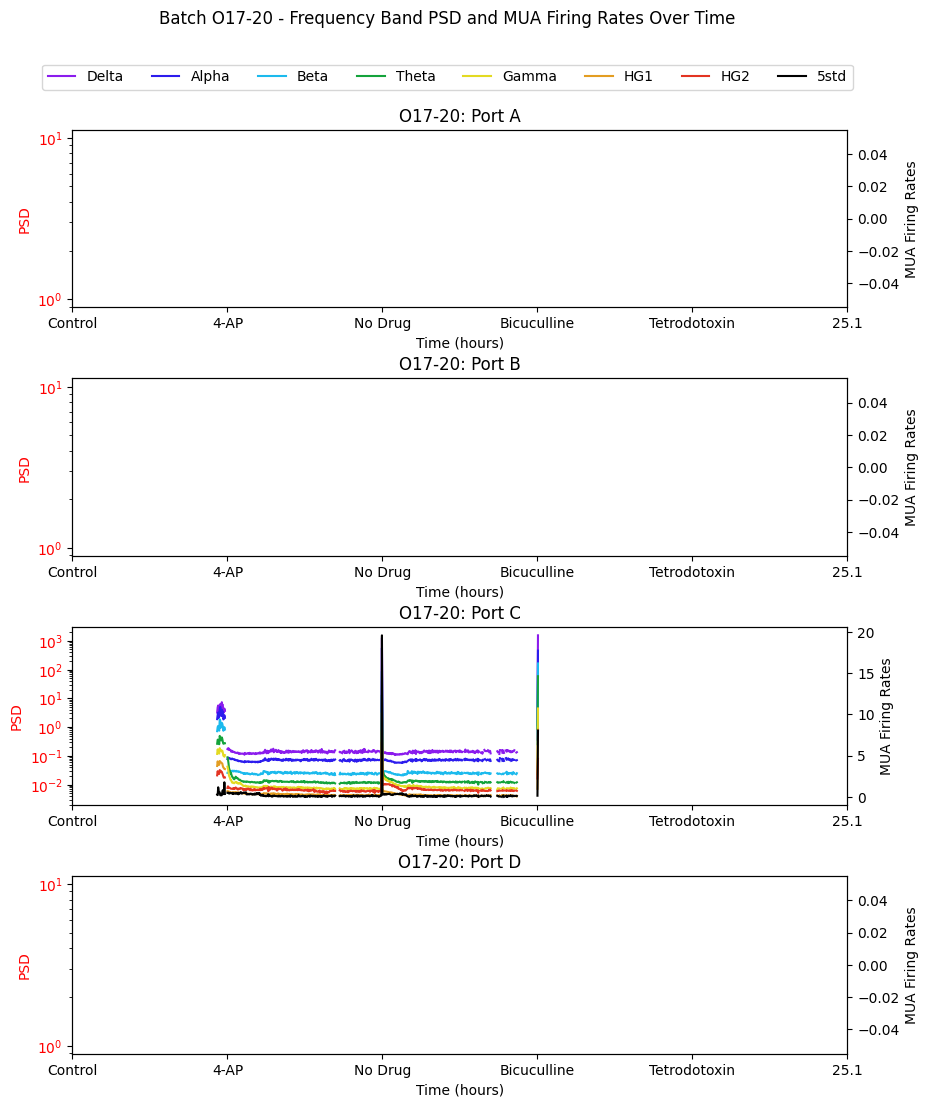

/var/folders/kj/qkc_fs3j2rx6nfm3mpsqdf940000gn/T/ipykernel_2534/4006353538.py:27: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


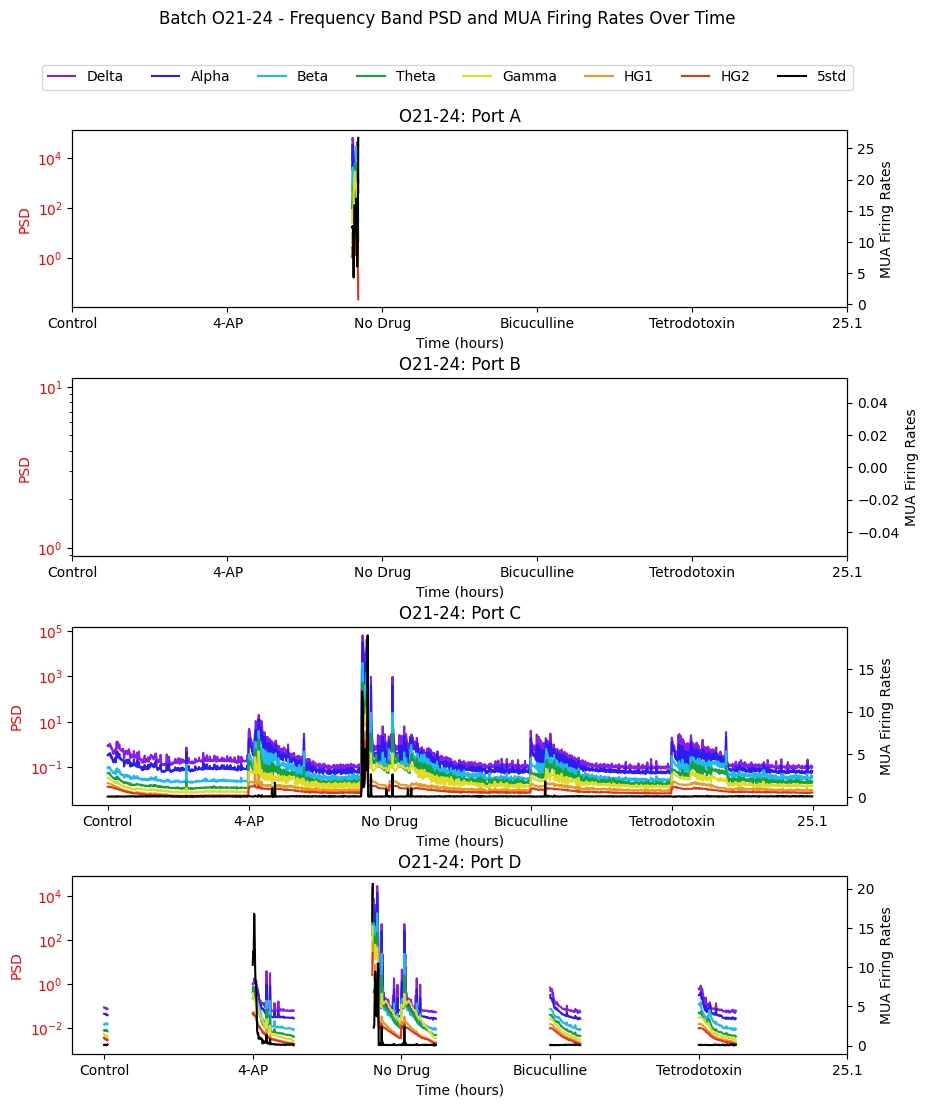

/var/folders/kj/qkc_fs3j2rx6nfm3mpsqdf940000gn/T/ipykernel_2534/4006353538.py:27: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


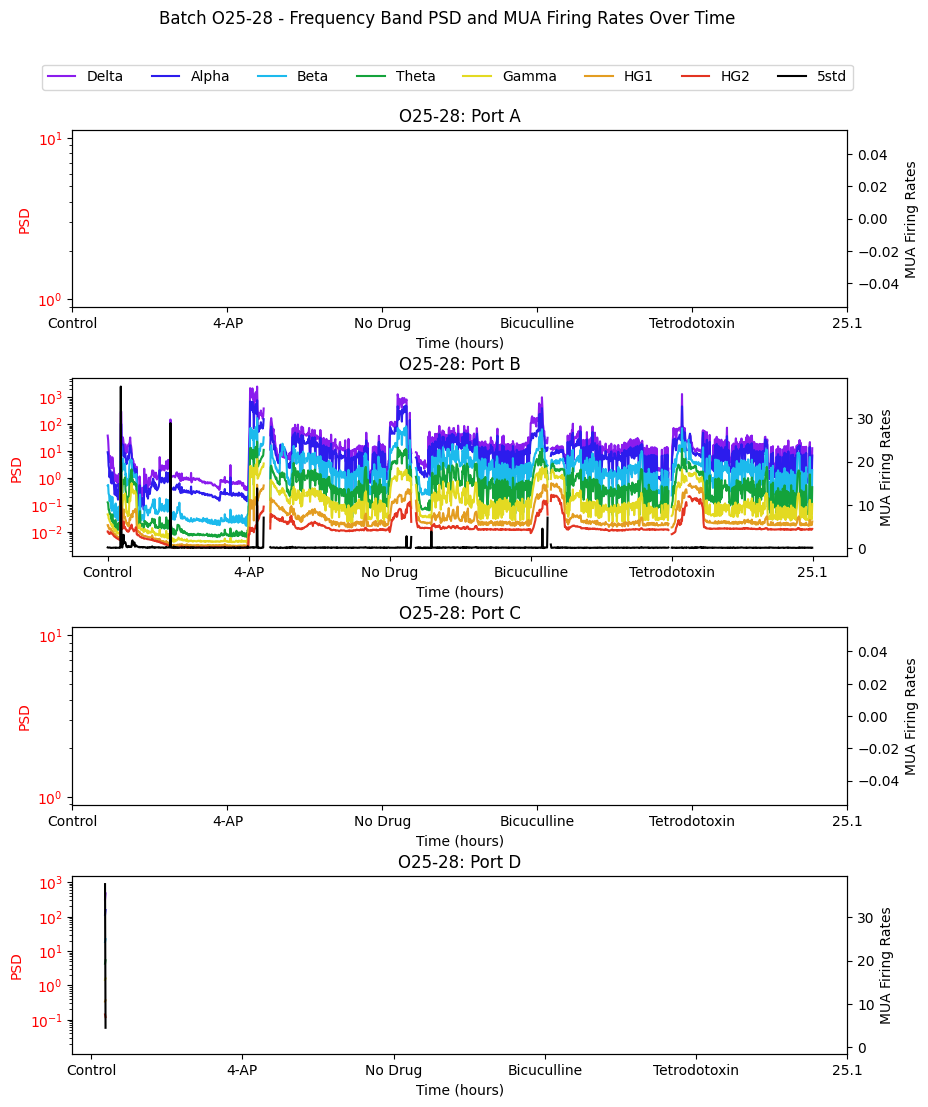

In [415]:
# Create a B Ox1 Figures 
# Each subplot will contain ax1(time vs PSD), ax2(time vs firing rate) for each organoid
# time will span across all drug time windows
# x-label will have 0 and total (# mins) and the drug labels

B = len(data) # num batches
feature_mask = np.array([True, True, True, True, True, True, True, False, False, True]) # take out 35uV and 4i thresholds

feature_names = np.array(["Delta", "Alpha", "Beta", "Theta", "Gamma", "HG1", "HG2", "35uV", "4std", "5std"])[feature_mask]
organoid_names = np.array(["Port A", "Port B", "Port C", "Port D"])
colors = np.array(["#8b1ced", "#2c1ced", "#1cbaed", "#14a33b", "#e3da22", "#e39d22", "#e33422", "#a2a2a2", "#5f5f5f", "#000000"])[feature_mask]

for batch, batch_dict in data.items():

    batch_data = []
    drug_idx = []
    for drug, (drug_data, mask) in batch_dict.items():

        # get filter for valid channels
        data_mask = get_total_mask(mask)
        drug_mask = np.tile(data_mask[:,:,:,np.newaxis], (1,1,1,10))

        # apply mask
        drug_data = apply_mask(drug_data, drug_mask)

        # average acrosss channels
        average_data = np.nanmean(drug_data, axis=1)

        # remove unwanted features
        average_data = average_data[:, :, feature_mask]

        # add drug index
        drug_idx.append(average_data.shape[1])

        # append to batch data list
        batch_data.append(average_data)
    drug_idx = np.cumsum(drug_idx)
    batch_data = np.concatenate(batch_data, axis=1) # organoid x time(min) x feature

    [O,T,F] = np.shape(batch_data)
    t = np.arange(T) # time (min)

    # Create a figure for each batch
    fig, axs = plt.subplots(O, 1, figsize=(10, 3*O))
    
    # Plot data for each organoid
    lines1 = []
    labels1 = []
    lines2 = []
    labels2 = []
    
    for o, ax in enumerate(axs):
        # Plot frequency band PSD (f=0:7) on the left axis
        for f in range(7):
            line = ax.plot(t, batch_data[o, :, f], color=colors[f], label=feature_names[f])[0]
            if o==1:
                lines1.append(line)
                labels1.append(feature_names[f])
        ax.set_yscale('log')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('PSD', color='r')
        ax.tick_params(axis='y', labelcolor='r')
        
        # Plot MUA firing rates (f=7:10) on the right axis
        ax2 = ax.twinx()
        for f in range(7, len(feature_names)):
            line = ax2.plot(t, batch_data[o, :, f], color=colors[f], label=feature_names[f])[0]
            if o==1:
                lines2.append(line)
                labels2.append(feature_names[f])
        
        ax2.set_ylabel('MUA Firing Rates', color='k')
        ax2.tick_params(axis='y', labelcolor='k')
        
        # Set xticks
        drug_names = list(batch_dict.keys()) + [np.round(T/60, decimals=1)]
        xticks = [0]+ drug_idx[:-1].tolist() + [T]  # Exclude the last drug index
        ax.set_xticks(xticks)
        ax.set_xticklabels(drug_names)
        
        ax.set_title(f'{batch}: {organoid_names[o]}')
    
    # Combine legends across all subplots and place at the top
    fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', ncol=len(feature_names), bbox_to_anchor=(.5, .94))

    
    plt.subplots_adjust(hspace=.4)
    
    fig.suptitle(f'Batch {batch} - Frequency Band PSD and MUA Firing Rates Over Time')
    plt.show()
